In [1]:
import os
import sys
import glob

import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import dill
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader,random_split, Subset, ConcatDataset
from tqdm import tqdm

import tsgm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE import GPVAE
from Models.PIVAE import PIVAE
from Models.PIGPVAE_lognorm import PIGPVAE
from metrics import *

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file

warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
df.loc[:, 'sur_temp'] = (df['RTD420'] + df['RTD417'] + df['B.ASTRHT2.T'])/3 
df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
# Remove rows where 'interval' is 53 or 5 from df_h
excluded_intervals = [53, 5]
# Filter the DataFrame
df_h_filtered = df_h[~df_h['interval'].isin(excluded_intervals)].reset_index(drop=True)
df_h = df_h_filtered

class RICO4dataset_GPVAE(Dataset):
    def __init__(self, df_h):
        self.df_h = df_h
        self.unique_intervals = df_h['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df_h['interval'] == batch
        temp = torch.tensor(self.df_h[id]['B.RTD1'].to_numpy(), dtype=torch.float32)
        ti = torch.tensor(self.df_h[id]['time_within_interval'].to_numpy()/240, dtype=torch.float32)
        x_batch = torch.cat((temp.unsqueeze(1), ti.unsqueeze(1)), axis=1)
        return x_batch
        
dataset_GPVAE = RICO4dataset_GPVAE(df_h)
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset_GPVAE)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset_GPVAE
train_subset_GPVAE, test_subset_GPVAE = random_split(
    dataset_GPVAE,
    [train_size, test_size],
    generator=generator
)
train_loader_GPVAE = DataLoader(train_subset_GPVAE, batch_size=1, shuffle=False)
val_loader_GPVAE = DataLoader(test_subset_GPVAE, batch_size=1, shuffle=False)

class RICO4Dataset_PIGPVAE(Dataset):
    def __init__(self, df, select_var, exclude_samples=None):
        """
        Args:
            df: DataFrame containing the data.
            select_var: List of variables to include in the dataset.
            exclude_samples: List of samples (intervals) to exclude from the dataset.
        """
        self.df = df
        self.select_var = select_var
        if exclude_samples:
            self.unique_batches = [batch for batch in df['interval'].unique() if batch not in exclude_samples]
        else:
            self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch

# Initialize the dataset_PIGPVAE, excluding samples 53 and 5
exclude_samples = [53, 5]
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset_PIGPVAE = RICO4Dataset_PIGPVAE(df_h, select_var, exclude_samples=exclude_samples)

# Validate the updated dataset_PIGPVAE
print(f"Dataset length after exclusion: {len(dataset_PIGPVAE)}")

# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset_PIGPVAE)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Define a fixed seed for reproducibility

seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset_PIGPVAE
train_subset_PIGPVAE, test_subset_PIGPVAE = random_split(
    dataset_PIGPVAE,
    [train_size, test_size],
    generator=generator
)
train_loader_PIGPVAE = DataLoader(train_subset_PIGPVAE, batch_size=1, shuffle=False)
val_loader_PIGPVAE = DataLoader(test_subset_PIGPVAE, batch_size=1, shuffle=False)

Dataset length after exclusion: 29


/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_23840/67997699.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
GPVAE_model = GPVAE(GP_inf = GP_inference(kernel),
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10])
GPVAE_model.load_state_dict(torch.load('pre_trained_models/GPVAE_heating.pth'))

<All keys matched successfully>

In [4]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)) 
GP_inf = GP_inference(kernel)
PIGPVAE_model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ELU(),
                mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
               )
PIGPVAE_model.load_state_dict(torch.load('pre_trained_models/PIGPVAE_heating.pth'))

<All keys matched successfully>

In [5]:
PIVAE_model = PIVAE(hidden_layers=[10,10], 
                    activation=nn.Tanh(),
                    mu_prior=torch.tensor(0),
                    var_prior=torch.tensor(2.0))
PIVAE_model.load_state_dict(torch.load('pre_trained_models/PIVAE_heating.pth'))

<All keys matched successfully>

In [6]:
with open('pre_trained_models/timegan_heating.pkl', 'rb') as f:
    timeGAN_model = dill.load(f)


In [7]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)

In [8]:
full_data = DataLoader(dataset_GPVAE)
original_data_list = []
for batch in full_data:
    original_data_list.append(batch[0][:,0])

original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)

In [9]:
# GPVAE generation related quantities
q_mu_l=[]
for x_batch in dataset_GPVAE:
    with torch.no_grad():
        # Pass the batch through the GPVAE_model
        _, _, _, _, q_mu_i, _ = GPVAE_model(x_batch.squeeze())  
        q_mu_l.append(q_mu_i)
mu_s_GPVAE = torch.cat(q_mu_l, dim=1).mean(dim=1).unsqueeze(1)

In [10]:
ns = total_size

In [11]:
# Initialize metric storage
mmd_values = []
correlation_metrics = []
mdd_values = []

# Number of generated datasets
num_datasets = 100

# Torch manual seed for reproducibility
torch.manual_seed(0)

# Instantiate the metrics class
metrics = SyntheticDataMetrics()

# Loop to generate datasets and compute metrics
for i in range(num_datasets):
    # Generate synthetic data
    gd_l_GPVAE, _ = GPVAE_model.generate_and_plot(mu_s_GPVAE, t_uni / 240, ns, (10, 35), df_h, plot=False, seed=i)
    
    # Stack the generated data into a tensor
    Gd_GPVAE = torch.stack(gd_l_GPVAE)
    
    # Compute MMD metric
    mmd_value = metrics.compute_mmd(original_data, Gd_GPVAE)
    mmd_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_GPVAE)
    correlation_metrics.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_GPVAE)
    mdd_values.append(mdd_value)

# Convert lists to tensors for further processing
mmd_GPVAE_tensor = torch.tensor(mmd_values)
correlation_metric_GPVAE_tensor = torch.tensor(correlation_metrics)
mdd_metric_GPVAE_tensor = torch.tensor(mdd_values)

# Print min and max for each metric
print("MMD - Min:", mmd_GPVAE_tensor.min().item(), "Max:", mmd_GPVAE_tensor.max().item())
print("Correlation Metric - Min:", correlation_metric_GPVAE_tensor.min().item(), "Max:", correlation_metric_GPVAE_tensor.max().item())
print("MDD - Min:", mdd_metric_GPVAE_tensor.min().item(), "Max:", mdd_metric_GPVAE_tensor.max().item())


MMD - Min: 0.07514086784794927 Max: 0.10627826629206538
Correlation Metric - Min: 337.0693359375 Max: 661.1079711914062
MDD - Min: 0.051149416769247516 Max: 0.06752873541316387


### PIVAE MMD 

In [12]:
x_hat, mu, var = {}, {}, {}
for x_batch in train_loader_PIGPVAE:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary
        x_hat[x_batch], mu[x_batch], var[x_batch] = PIVAE_model(x_batch)

mu_tensor = torch.cat([mu[batch] for batch in mu.keys()], dim=0)
var_tensor = torch.cat([var[batch] for batch in var.keys()], dim=0)
mu_PIVAE_post = mu_tensor.mean()
var_PIVAE_post = var_tensor.mean()

### PIGPVAE MMD 

In [13]:
q_mu_delta_l,  q_mu_phy_l, q_var_phy_l = [], [], []

# Iterate through the train_loader_GPVAE to obtain x_batch
for x_batch in train_loader_PIGPVAE:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary

        # Forward pass through the model
        _, _, _, _, _, _, q_mu_delta_i, _, q_mu_phy_i, q_var_phy_i = PIGPVAE_model(x_batch)

        # Append the required quantities
        q_mu_delta_l.append(q_mu_delta_i)
        q_mu_phy_l.append(q_mu_phy_i)
        q_var_phy_l.append(q_var_phy_i)

mean_q_mu_phy = sum(q_mu_phy_l) / len(q_mu_phy_l)
mean_q_var_phy = sum(q_var_phy_l) / len(q_var_phy_l)

mu_s_PIGPVAE = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


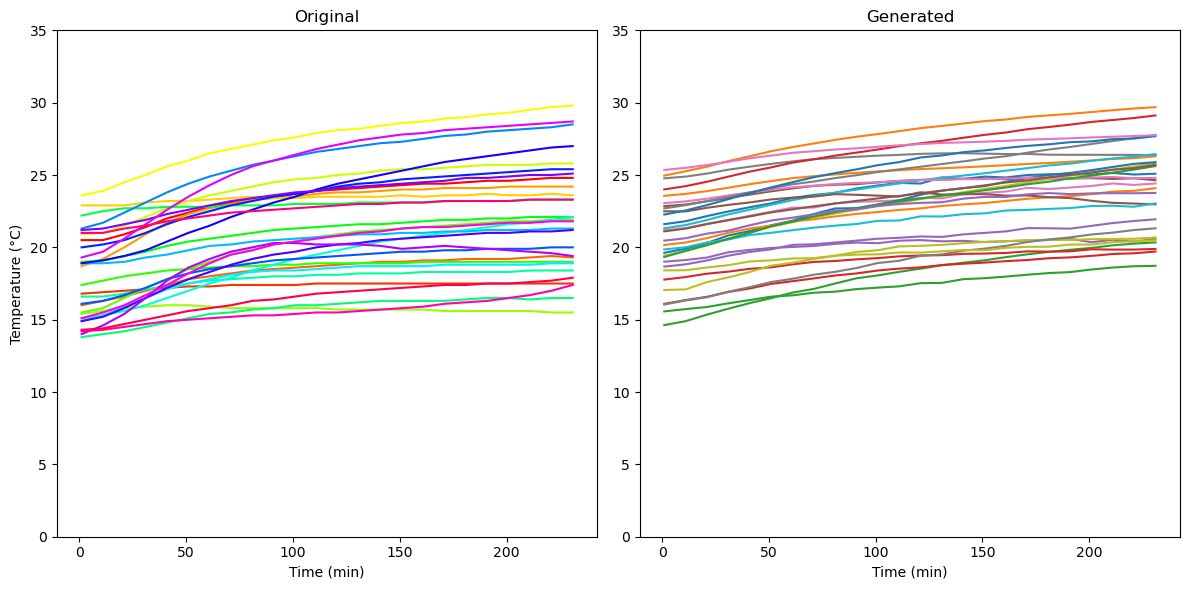

In [14]:
ns = total_size
min_T, max_T = 14, 30
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, gd_l_PIGPVAE, fig, axs=PIGPVAE_model.generate_and_plot(mu_s_PIGPVAE, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(0, 35),
                        plot=True, seed=0)
Gd_PIGPVAE = torch.stack(gd_l_PIGPVAE)


In [15]:
# Initialize metric storage
mmd_PIGPVAE_values = []
correlation_metrics_PIGPVAE = []
mdd_values_PIGPVAE = []

# Set parameters for synthetic data generation
num_datasets = 100
min_T, max_T = 10, 32

torch.manual_seed(0)

# Loop to generate datasets and compute metrics
for i in range(num_datasets):
    # Generate random T0 and Ts
    T0 = min_T + (max_T - min_T) * torch.rand(ns)
    difference = 1 + (20 - 1) * torch.rand(ns)
    Ts = T0 + difference

    # Generate synthetic data
    k_values, gd_l_PIGPVAE, fig, axs = PIGPVAE_model.generate_and_plot(
        mu_s_PIGPVAE,
        mean_q_mu_phy,
        mean_q_var_phy,
        df=df_h,
        num_unique_intervals=num_unique_intervals,
        ns=ns,
        T0=T0,
        Ts=Ts,
        t_uni=t_uni / 240,
        axs_ylim=(0, 35),
        plot=False,
        seed=i
    )
    
    # Stack generated data
    Gd_PIGPVAE = torch.stack(gd_l_PIGPVAE)
    
    # Compute MMD
    mmd_value = metrics.compute_mmd(original_data, Gd_PIGPVAE)
    mmd_PIGPVAE_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_PIGPVAE)
    correlation_metrics_PIGPVAE.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_PIGPVAE)
    mdd_values_PIGPVAE.append(mdd_value)

# Convert lists to tensors for further processing
mmd_PIGPVAE_tensor = torch.tensor(mmd_PIGPVAE_values)
correlation_metric_PIGPVAE_tensor = torch.tensor(correlation_metrics_PIGPVAE)
mdd_metric_PIGPVAE_tensor = torch.tensor(mdd_values_PIGPVAE)

# Print min and max for each metric
print("PIGPVAE Metrics:")
print("MMD - Min:", mmd_PIGPVAE_tensor.min().item(), "Max:", mmd_PIGPVAE_tensor.max().item())
print("Correlation Metric - Min:", correlation_metric_PIGPVAE_tensor.min().item(), "Max:", correlation_metric_PIGPVAE_tensor.max().item())
print("MDD - Min:", mdd_metric_PIGPVAE_tensor.min().item(), "Max:", mdd_metric_PIGPVAE_tensor.max().item())


PIGPVAE Metrics:
MMD - Min: 0.06299849413335323 Max: 0.08436392503790557
Correlation Metric - Min: 88.08976745605469 Max: 153.6414337158203
MDD - Min: 0.012915506379817934 Max: 0.03969062868742346


In [16]:
# Initialize metric storage
mmd_PIVAE_values = []
correlation_metrics_PIVAE = []
mdd_values_PIVAE = []

# Number of datasets to generate
num_datasets = 100
min_T, max_T = 12, 28

# Loop to generate datasets and compute metrics
for i in range(num_datasets):
    torch.manual_seed(i)  # Set seed for reproducibility
    
    # Generate random T0 and Ts
    T0 = min_T + (max_T - min_T) * torch.rand(ns)
    difference = 1 + (20 - 1) * torch.rand(ns)
    Ts = T0 + difference
    
    # Generate synthetic data using PIVAE model
    gd_l_PIVAE, _ = PIVAE_model.generate(
        mu_post=mu_PIVAE_post,
        var_post=var_PIVAE_post,
        T0=T0,
        t=t_uni,
        Ts=Ts
    )
    
    # Stack generated data
    Gd_PIVAE = torch.stack(gd_l_PIVAE)
    
    # Compute MMD
    mmd_value = metrics.compute_mmd(original_data, Gd_PIVAE)
    mmd_PIVAE_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_PIVAE)
    correlation_metrics_PIVAE.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_PIVAE)
    mdd_values_PIVAE.append(mdd_value)

# Convert lists to tensors for further processing
mmd_PIVAE_tensor = torch.tensor(mmd_PIVAE_values)
correlation_metric_PIVAE_tensor = torch.tensor(correlation_metrics_PIVAE)
mdd_metric_PIVAE_tensor = torch.tensor(mdd_values_PIVAE)

# Compute and print min and max values for each metric
print(f"Min MMD: {mmd_PIVAE_tensor.min().item()}, Max MMD: {mmd_PIVAE_tensor.max().item()}")
print(f"Min Correlation Metric: {correlation_metric_PIVAE_tensor.min().item()}, Max Correlation Metric: {correlation_metric_PIVAE_tensor.max().item()}")
print(f"Min MDD: {mdd_metric_PIVAE_tensor.min().item()}, Max MDD: {mdd_metric_PIVAE_tensor.max().item()}")


Min MMD: 0.07137942453846335, Max MMD: 0.08382420823909342
Min Correlation Metric: 83.60778045654297, Max Correlation Metric: 106.03504943847656
Min MDD: 0.03774764050576079, Max MDD: 0.0754811547628781


In [17]:
# Initialize metric storage
mmd_timeGAN_values = []
correlation_metrics_timeGAN = []
mdd_values_timeGAN = []

def timeGAN_transform(X, min=20.5, max=29.8):
    return X*(max-min)+min
# Number of generated datasets
num_datasets = 100
tf.random.set_seed(42)

# Loop to generate datasets and compute metrics
for i in range(num_datasets):
    # Generate synthetic data
    gd_l_timeGAN = timeGAN_model.generate(n_samples=ns)
    gd_l_timeGAN = timeGAN_transform(gd_l_timeGAN)
    gd_l_timeGAN = [torch.tensor(gd_l_timeGAN[i]) for i in range(gd_l_timeGAN.shape[0])]
    
    # Stack the generated data into a tensor
    Gd_timeGAN = torch.stack(gd_l_timeGAN)
    
    # Compute MMD metric
    mmd_value = metrics.compute_mmd(original_data, Gd_timeGAN)
    mmd_timeGAN_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, gd_l_timeGAN)
    correlation_metrics_timeGAN.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, gd_l_timeGAN)
    mdd_values_timeGAN.append(mdd_value)

# Convert lists to tensors for further processing
mmd_timeGAN_tensor = torch.tensor(mmd_timeGAN_values)
correlation_metric_timeGAN_tensor = torch.tensor(correlation_metrics_timeGAN)
mdd_metric_timeGAN_tensor = torch.tensor(mdd_values_timeGAN)

# Compute and print min and max values for each metric
print(f"Min MMD: {mmd_timeGAN_tensor.min().item()}, Max MMD: {mmd_timeGAN_tensor.max().item()}")
print(f"Min Correlation Metric: {correlation_metric_timeGAN_tensor.min().item()}, Max Correlation Metric: {correlation_metric_timeGAN_tensor.max().item()}")
print(f"Min MDD: {mdd_metric_timeGAN_tensor.min().item()}, Max MDD: {mdd_metric_timeGAN_tensor.max().item()}")


Synthetic data generation: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

Min MMD: 0.07336290483362973, Max MMD: 0.12307722913101315
Min Correlation Metric: 172.14468383789062, Max Correlation Metric: 503.5335693359375
Min MDD: 0.053879306204634304, Max MDD: 0.057614940379889915


In [18]:
# Initialize metric storage
mmd_TimeVQVAE_values = []
correlation_metrics_TimeVQVAE = []
mdd_values_TimeVQVAE = []
# Loop to generate datasets and compute metrics
# Specify the folder containing CSV files
folder_path = 'TimeVQVAE_gen_data/heating/'

# Use glob to get all CSV file paths
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# List to store the tensors for each DataFrame
TimeVQVAE_tensors_list = []

# Process each CSV file
for i, file in enumerate(csv_files):
    # Load the DataFrame
    df = pd.read_csv(file)
    
    # Convert each row to a PyTorch tensor of size [24, 1]
    tensor_list = [torch.tensor(row.values, dtype=torch.float32).view(24, 1) for _, row in df.iterrows()]
    
    Gd_TimeVQVAE = torch.stack(tensor_list)
    # Add the list of tensors to the overall list
    TimeVQVAE_tensors_list.append(Gd_TimeVQVAE)
    
    
    # Compute MMD
    mmd_value = metrics.compute_mmd(original_data, Gd_TimeVQVAE)
    mmd_TimeVQVAE_values.append(mmd_value)
    
    # Compute Correlation Metric
    correlation_metric_value = metrics.correlation_metric(original_data, Gd_TimeVQVAE)
    correlation_metrics_TimeVQVAE.append(correlation_metric_value)
    
    # Compute MDD
    mdd_value = metrics.compute_mdd(original_data, Gd_TimeVQVAE)
    mdd_values_TimeVQVAE.append(mdd_value)

# Convert lists to tensors for further processing
mmd_TimeVQVAE_tensor = torch.tensor(mmd_TimeVQVAE_values)
correlation_metric_TimeVQVAE_tensor = torch.tensor(correlation_metrics_TimeVQVAE)
mdd_metric_TimeVQVAE_tensor = torch.tensor(mdd_values_TimeVQVAE)

# Compute and print min and max values for each metric
print(f"Min MMD: {mmd_TimeVQVAE_tensor.min().item()}, Max MMD: {mmd_TimeVQVAE_tensor.max().item()}")
print(f"Min Correlation Metric: {correlation_metric_TimeVQVAE_tensor.min().item()}, Max Correlation Metric: {correlation_metric_TimeVQVAE_tensor.max().item()}")
print(f"Min MDD: {mdd_metric_TimeVQVAE_tensor.min().item()}, Max MDD: {mdd_metric_TimeVQVAE_tensor.max().item()}")


Min MMD: 0.12220800807699561, Max MMD: 0.23195893596857786
Min Correlation Metric: 91.24998474121094, Max Correlation Metric: 93.76216888427734
Min MDD: 0.05528124646412268, Max MDD: 0.06656485684893935


In [19]:
# Provided tensors
mmd_tensors = {
    "PIGPVAE": mmd_PIGPVAE_tensor,
    "PIVAE": mmd_PIVAE_tensor,
    "GPVAE": mmd_GPVAE_tensor,
    "TimeGAN": mmd_timeGAN_tensor,
    "TimeVQVAE": mmd_TimeVQVAE_tensor,
}
correlation_tensors = {
    "PIGPVAE": correlation_metric_PIGPVAE_tensor,
    "PIVAE": correlation_metric_PIVAE_tensor,
    "GPVAE": correlation_metric_GPVAE_tensor,
    "TimeGAN": correlation_metric_timeGAN_tensor,
    "TimeVQVAE": correlation_metric_TimeVQVAE_tensor,
}
mdd_tensors = {
    "PIGPVAE": mdd_metric_PIGPVAE_tensor,
    "PIVAE": mdd_metric_PIVAE_tensor,
    "GPVAE": mdd_metric_GPVAE_tensor,
    "TimeGAN": mdd_metric_timeGAN_tensor,
    "TimeVQVAE": mdd_metric_TimeVQVAE_tensor,
}

# Combine all metrics into a single table
combined_results = {
    "Model": list(mmd_tensors.keys()),
    "MMD Mean (Std)": [
        f"{tensor.mean().item():.4f} ({tensor.std().item():.4f})" for tensor in mmd_tensors.values()
    ],
    "Correlation Mean (Std)": [
        f"{tensor.mean().item():.4f} ({tensor.std().item():.4f})" for tensor in correlation_tensors.values()
    ],
    "MDD Mean (Std)": [
        f"{tensor.mean().item():.4f} ({tensor.std().item():.4f})" for tensor in mdd_tensors.values()
    ],
}

# Create a DataFrame for combined results
combined_results_df = pd.DataFrame(combined_results)

# Export the DataFrame to LaTeX format
latex_output = combined_results_df.to_latex(index=False)

# Save the LaTeX table
with open("tables/Metrics_heating_limited.tex", "w") as f:
    f.write(latex_output)

# Display the formatted table
print("Combined Metrics Results:")
print(combined_results_df)


Combined Metrics Results:
       Model   MMD Mean (Std) Correlation Mean (Std)   MDD Mean (Std)
0    PIGPVAE  0.0733 (0.0042)       98.1113 (8.7819)  0.0259 (0.0056)
1      PIVAE  0.0757 (0.0025)       96.0600 (3.0710)  0.0571 (0.0082)
2      GPVAE  0.0848 (0.0047)     504.6981 (76.9627)  0.0610 (0.0033)
3    TimeGAN  0.0930 (0.0101)     350.4160 (62.7448)  0.0557 (0.0009)
4  TimeVQVAE  0.1626 (0.0224)       92.3075 (0.5471)  0.0608 (0.0023)


/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_23840/1642092395.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_23840/1642092395.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_23840/1642092395.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabe

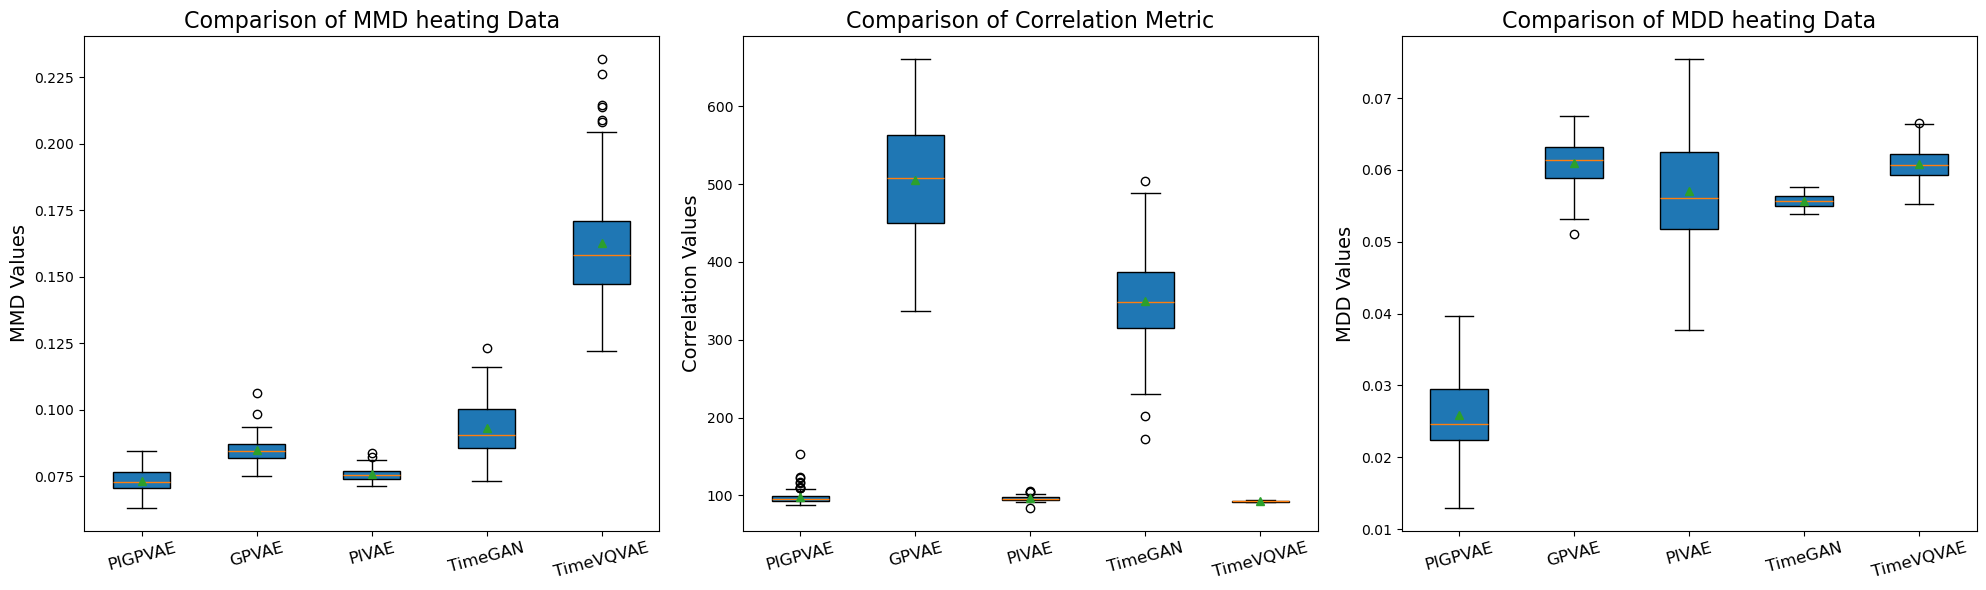

In [20]:
# Update labels to include TimeVQVAE
labels = ['PIGPVAE', 'GPVAE', 'PIVAE', 'TimeGAN', 'TimeVQVAE']

# Extract values as lists for each metric
mmd_data = [mmd_tensors[model].tolist() for model in labels]
correlation_data = [correlation_tensors[model].tolist() for model in labels]
mdd_data = [mdd_tensors[model].tolist() for model in labels]

# Combine all metrics into a single list
data_list = [mmd_data, correlation_data, mdd_data]

# Function to create side-by-side box plots with independent x-axes for each metric
def plot_side_by_side_independent(data_list, titles, ylabels, xlabels):
    fig, axes = plt.subplots(1, len(data_list), figsize=(20, 6))
    
    for i, data in enumerate(data_list):
        axes[i].boxplot(data, vert=True, patch_artist=True, labels=xlabels[i], showmeans=True)
        axes[i].set_title(titles[i], fontsize=16)
        axes[i].set_xticklabels(xlabels[i], fontsize=12, rotation=15)
        axes[i].set_ylabel(ylabels[i], fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Titles, y-labels, and x-labels for each metric
titles = ['Comparison of MMD heating Data', 
          'Comparison of Correlation Metric', 
          'Comparison of MDD heating Data']
ylabels = ['MMD Values', 'Correlation Values', 'MDD Values']
xlabels = [labels, labels, labels]

# Plot all metrics side by side with independent x-axes
plot_side_by_side_independent(data_list, titles, ylabels, xlabels)


In [21]:
# Function to find the two best-performing methods and perform a t-test
def compare_best_methods(data_list, labels, metric_names):
    results = {}

    for metric_idx, data in enumerate(data_list):
        # Compute mean values for each model
        mean_values = [np.mean(model_data) for model_data in data]
        
        # Get indices of the two best models (smallest mean values)
        sorted_indices = np.argsort(mean_values)[:2]
        best_model_1, best_model_2 = labels[sorted_indices[0]], labels[sorted_indices[1]]
        
        # Perform Welch’s t-test
        t_stat, p_value = stats.ttest_ind(data[sorted_indices[0]], data[sorted_indices[1]], equal_var=False)

        # Store results
        results[metric_names[metric_idx]] = {
            "Best Models": (best_model_1, best_model_2),
            "Mean Values": (mean_values[sorted_indices[0]], mean_values[sorted_indices[1]]),
            "t-statistic": t_stat,
            "p-value": p_value
        }

    return results

# Define metric names
metric_names = ["MMD", "Correlation", "MDD"]

# Run comparison and t-tests
results = compare_best_methods(data_list, labels, metric_names)

# Print results
for metric, res in results.items():
    print(f"\nMetric: {metric}")
    print(f"Best Models: {res['Best Models'][0]} ({res['Mean Values'][0]:.6f}), {res['Best Models'][1]} ({res['Mean Values'][1]:.6f})")
    print(f"T-statistic: {res['t-statistic']:.6f}, P-value: {res['p-value']:.6f}")



Metric: MMD
Best Models: PIGPVAE (0.073345), PIVAE (0.075651)
T-statistic: -4.678670, P-value: 0.000006

Metric: Correlation
Best Models: TimeVQVAE (92.307514), PIVAE (96.059951)
T-statistic: -12.029449, P-value: 0.000000

Metric: MDD
Best Models: PIGPVAE (0.025855), TimeGAN (0.055685)
T-statistic: -53.076301, P-value: 0.000000


In [22]:
min_T, max_T = 14, 25
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
gd_l_PIVAE, _ =PIVAE_model.generate(mu_post=mu_PIVAE_post, var_post=var_PIVAE_post, T0=T0 , t=t_uni/240, Ts=Ts)
Gd_PIVAE = torch.stack(gd_l_PIVAE) 

ns = total_size
gd_l_GPVAE, fig = GPVAE_model.generate_and_plot(mu_s_GPVAE, t_uni/240, ns, (10, 35), df_h, plot=False, seed=None)
Gd_GPVAE = torch.stack(gd_l_GPVAE)
min_T, max_T = 12, 28
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
k_values, gd_l_PIGPVAE, fig, axs=PIGPVAE_model.generate_and_plot(mu_s_PIGPVAE, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(0, 35),
                        plot=False, seed=123)
Gd_PIGPVAE = torch.stack(gd_l_PIGPVAE)
gd_l_timeGAN = timeGAN_model.generate(n_samples=ns)
gd_l_timeGAN = timeGAN_transform(gd_l_timeGAN)
gd_l_timeGAN = [torch.tensor(gd_l_timeGAN[i]) for i in range(gd_l_timeGAN.shape[0])]
Gd_timeGAN = torch.stack(gd_l_timeGAN)



/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
Synthetic data generation: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


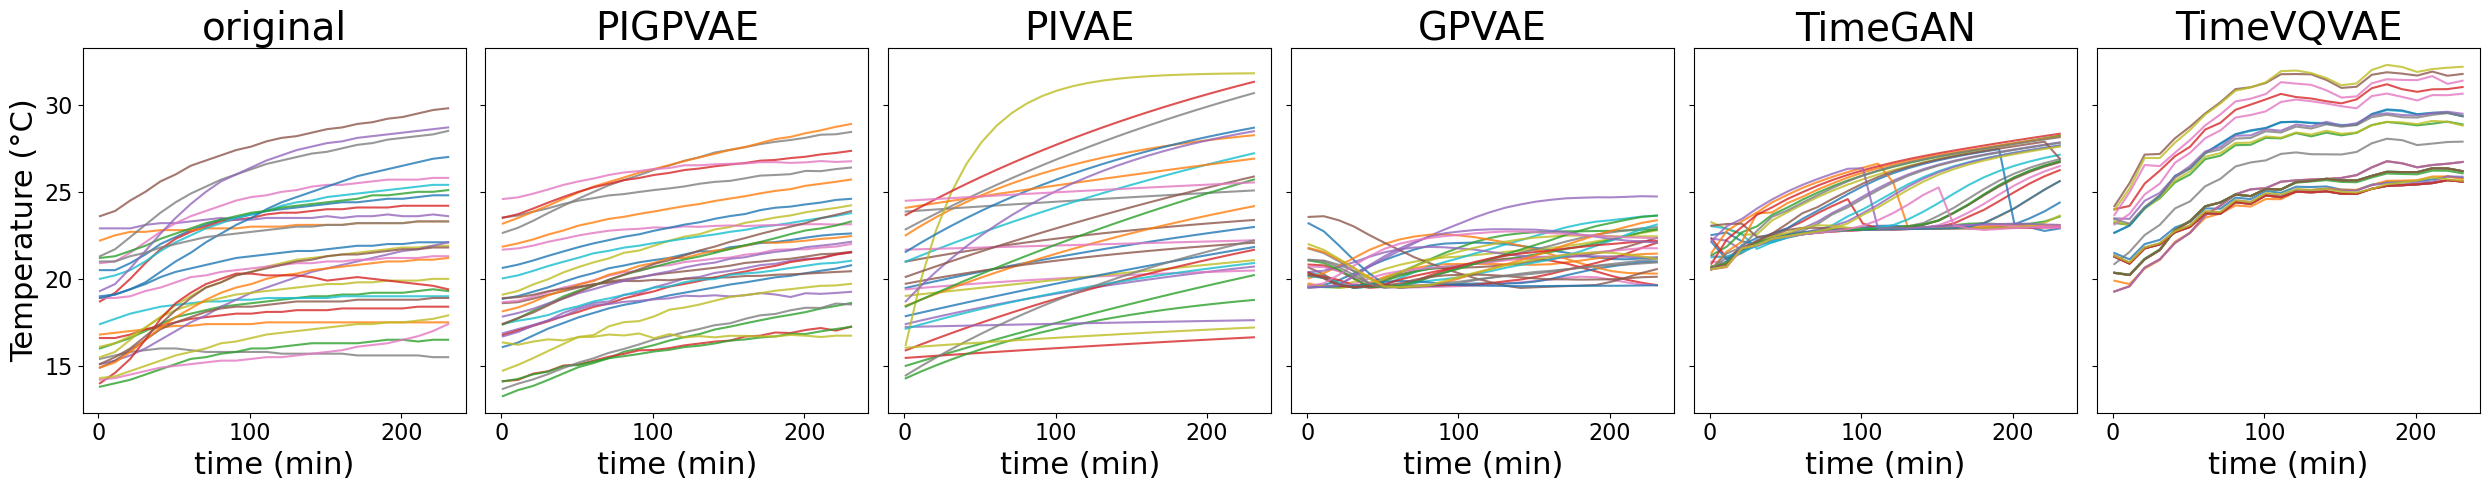

In [23]:
# Update datasets to include TimeVQVAE
datasets = [
    ("original", original_data), 
    ("PIGPVAE", Gd_PIGPVAE), 
    ("PIVAE", Gd_PIVAE), 
    ("GPVAE", Gd_GPVAE), 
    ("TimeGAN", Gd_timeGAN), 
    ("TimeVQVAE", Gd_TimeVQVAE)
]

# Create subplots for each dataset
fig, axes = plt.subplots(1, len(datasets), figsize=(25, 5), sharey=True)

# Define font size
title_fontsize = 28
label_fontsize = 22
tick_fontsize = 16

# Plot each dataset
for idx, (ax, (title, data)) in enumerate(zip(axes, datasets)):
    for ts in data:
        ax.plot(t_uni, ts.numpy(), alpha=0.8)
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("time (min)", fontsize=label_fontsize)
    
    # Set y-axis label only for the first plot
    if idx == 0:
        ax.set_ylabel("Temperature (°C)", fontsize=label_fontsize)
    
    # Increase font size for tick labels
    ax.tick_params(axis='both', labelsize=tick_fontsize)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("figs/heating_visual_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()


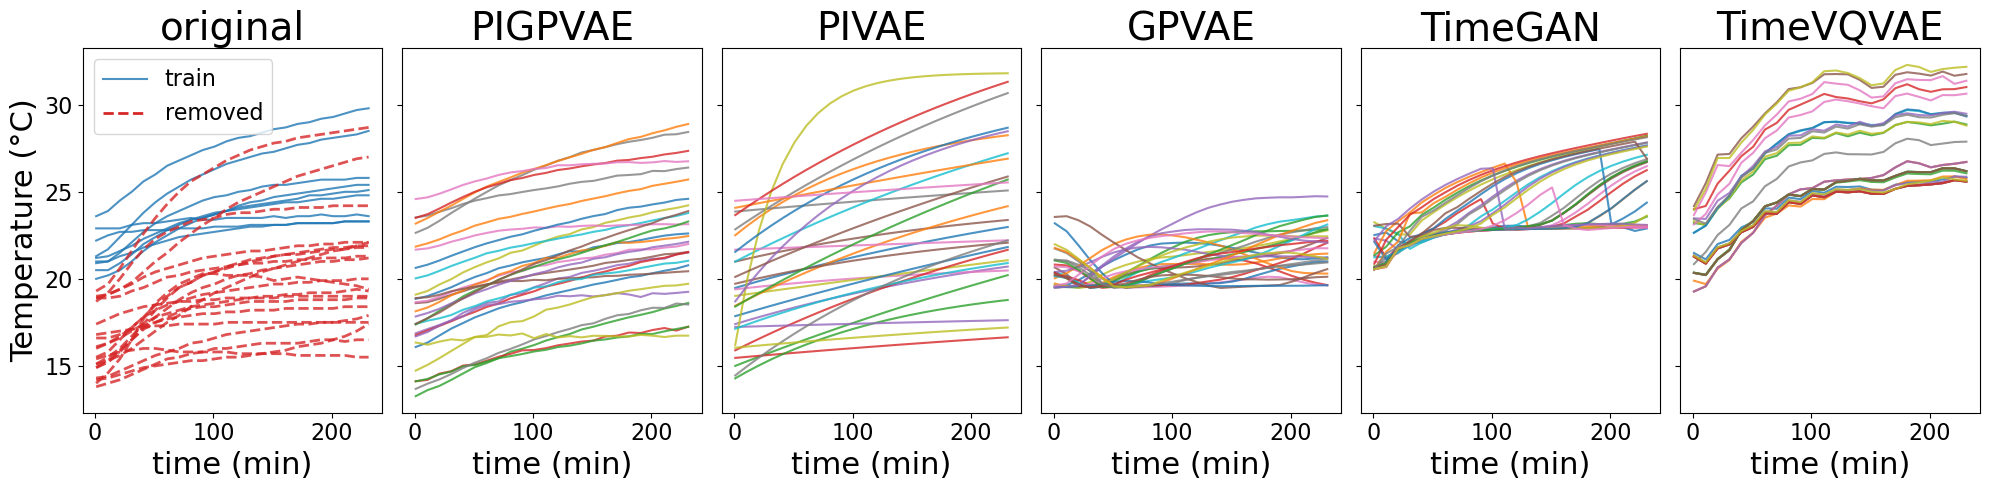

In [25]:
fig, axes = plt.subplots(1, len(datasets), figsize=(20, 5), sharey=True)

# Define font size
title_fontsize = 28
label_fontsize = 22
tick_fontsize = 16

for idx, (ax, (title, data)) in enumerate(zip(axes, datasets)):
    if title == "original":
        grey_label_added = False  # Track if legend for "removed" has been added
        blue_label_added = False  # Track if legend for "train" has been added

        # Plot train data first (non-removed, default blue)
        for ts in data:
            if ts[0].numpy() >= 20:  # Train data (starting value >= 20)
                ax.plot(t_uni, ts.numpy(), color="#1f77b4", alpha=0.8, linewidth=1.5)
                if not blue_label_added:
                    ax.plot([], [], color="#1f77b4", label="train", alpha=0.8, linewidth=1.5)
                    blue_label_added = True

        # Plot removed data second (grey dashed lines)
        for ts in data:
            if ts[0].numpy() < 20:  # Removed data (starting value < 20)
                ax.plot(t_uni, ts.numpy(), color="#d62728", alpha=0.8, linestyle="--", linewidth=2)
                if not grey_label_added:
                    ax.plot([], [], color="#d62728", linestyle="--", label="removed", alpha=1, linewidth=2)
                    grey_label_added = True

        ax.legend(fontsize=tick_fontsize)  # Add legend for the "original" dataset
    else:
        for ts in data:
            ax.plot(t_uni, ts.numpy(), alpha=0.8)
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("time (min)", fontsize=label_fontsize)
    
    # Set y-axis label only for the first plot
    if idx == 0:
        ax.set_ylabel("Temperature (°C)", fontsize=label_fontsize)
    
    # Increase font size for tick labels
    ax.tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.savefig("figs/heating_visual_comparison_limited.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [26]:
ns=400
Gd_TimeVQVAE = torch.cat(TimeVQVAE_tensors_list, dim=0)[:ns,:,:]
min_T, max_T = 14, 25
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (15 - 1) * torch.rand(ns)
Ts = T0 + difference
gd_l_PIVAE, _ =PIVAE_model.generate(mu_post=mu_PIVAE_post, var_post=var_PIVAE_post, T0=T0 , t=t_uni/240, Ts=Ts)
Gd_PIVAE = torch.stack(gd_l_PIVAE) 

gd_l_GPVAE, fig = GPVAE_model.generate_and_plot(mu_s_GPVAE, t_uni/240, ns, (10, 35), df_h, plot=False, seed=None)
Gd_GPVAE = torch.stack(gd_l_GPVAE)

min_T, max_T = 12, 28
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
k_values, gd_l_PIGPVAE, fig, axs=PIGPVAE_model.generate_and_plot(mu_s_PIGPVAE, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(0, 35),
                        plot=False, seed=0)
Gd_PIGPVAE = torch.stack(gd_l_PIGPVAE)
gd_l_timeGAN = timeGAN_model.generate(n_samples=ns)
gd_l_timeGAN = timeGAN_transform(gd_l_timeGAN)
gd_l_timeGAN = [torch.tensor(gd_l_timeGAN[i]) for i in range(gd_l_timeGAN.shape[0])]
Gd_timeGAN = torch.stack(gd_l_timeGAN)

datasets = [("original", original_data), 
            ("PIGPVAE", Gd_PIGPVAE), 
            ("PIVAE", Gd_PIVAE), 
            ("GPVAE", Gd_GPVAE), 
            ("TimeGAN", Gd_timeGAN),
            ("TimeVQVAE", Gd_TimeVQVAE)]

/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
Synthetic data generation: 100%|██████████| 51/51 [00:14<00:00,  3.63it/s]


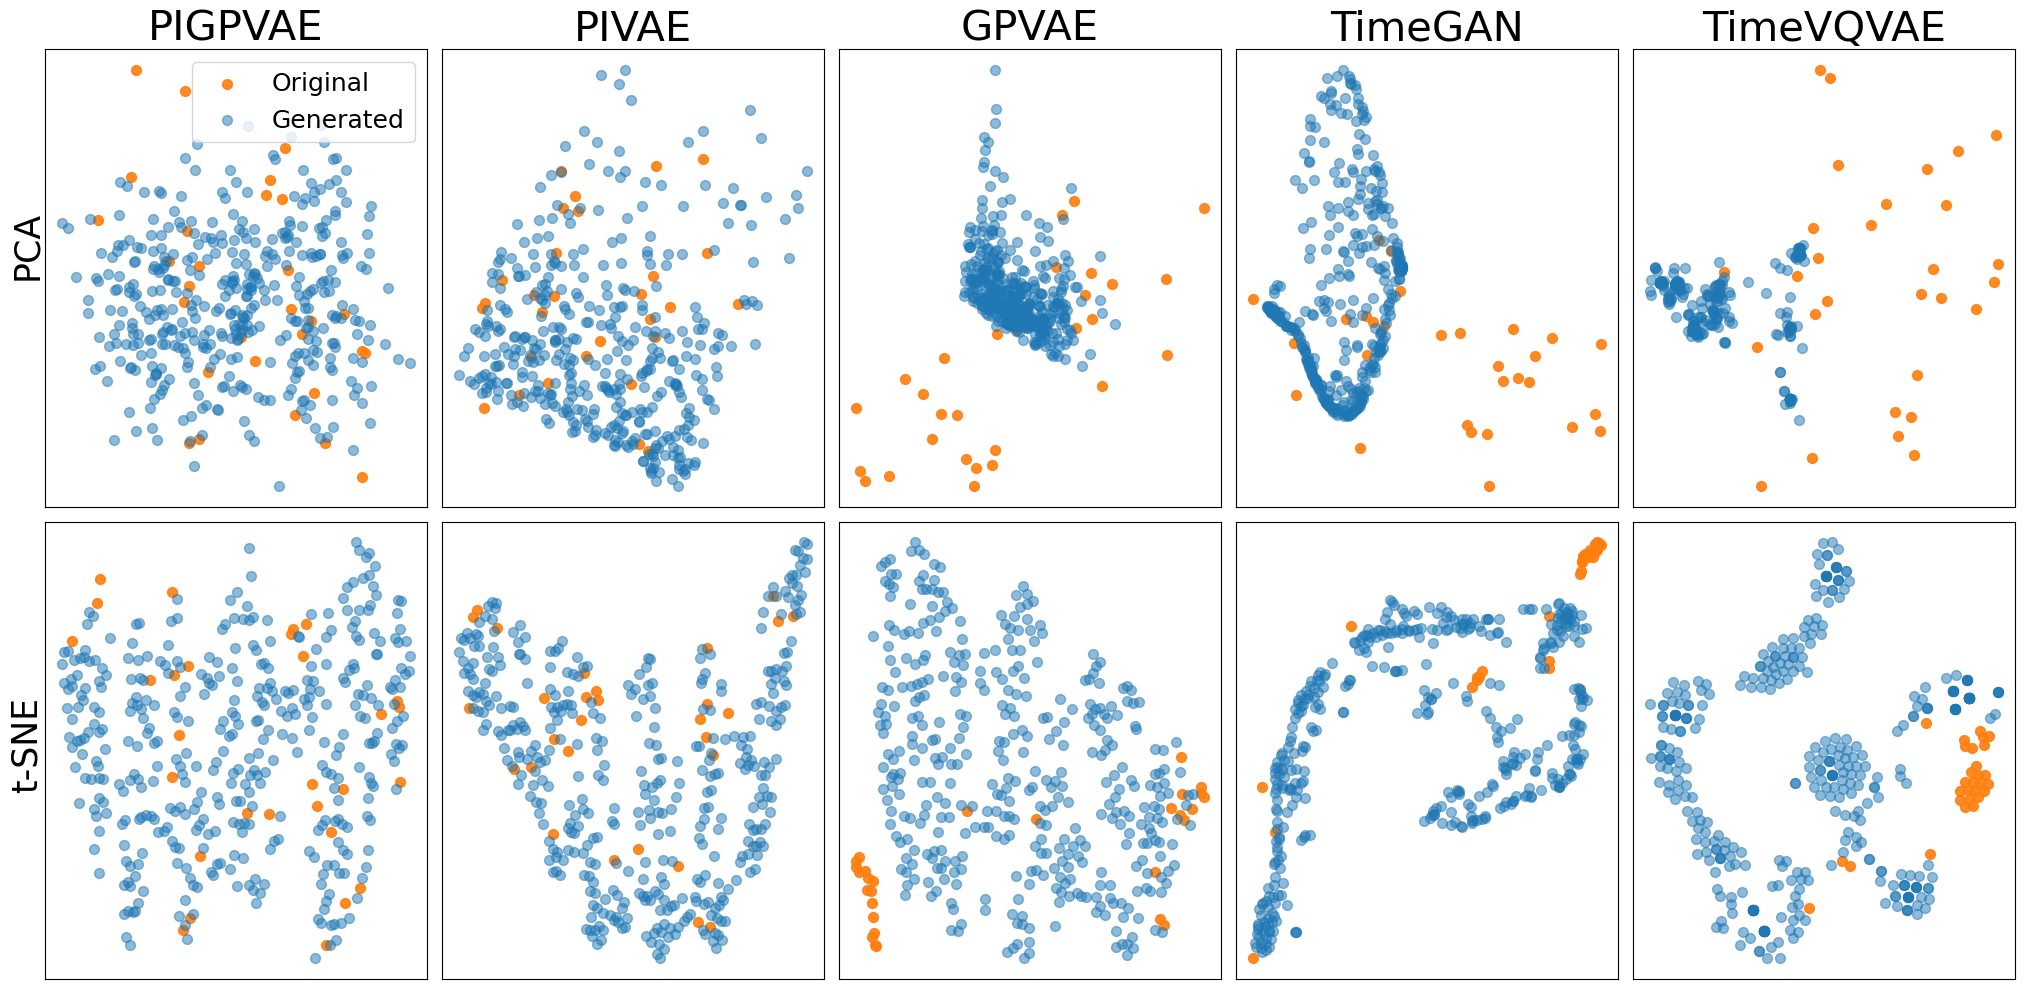

In [27]:
# Filter relevant datasets
methods_to_compare = ["PIGPVAE", "PIVAE", "GPVAE", "TimeGAN", "TimeVQVAE"]
filtered_datasets = [(name, data) for name, data in datasets if name in methods_to_compare]

# Prepare the original data
original_flattened = [ts.numpy().flatten() if isinstance(ts, torch.Tensor) else ts.flatten() for ts in original_data]
original_flattened = np.vstack(original_flattened)  # Convert to 2D array

# Set up subplots (2 rows: PCA and t-SNE)
fig, axes = plt.subplots(2, len(filtered_datasets), figsize=(20, 10), sharey=False)

# Font sizes
title_fontsize = 30
label_fontsize = 25

# Loop for PCA and t-SNE plots
for row, method in enumerate(["PCA", "t-SNE"]):
    for col, (name, data) in enumerate(filtered_datasets):
        ax = axes[row, col]
        
        # Flatten the generated data
        generated_flattened = [ts.numpy().flatten() if isinstance(ts, torch.Tensor) else ts.flatten() for ts in data]
        generated_flattened = np.vstack(generated_flattened)  # Convert to 2D array

        # Combine original and generated data
        combined_data = np.vstack([original_flattened, generated_flattened])
        labels = np.array(["Original"] * len(original_flattened) + ["Generated"] * len(generated_flattened))

        # Perform PCA or t-SNE
        if method == "PCA":
            pca = PCA(n_components=2)
            result = pca.fit_transform(combined_data)
        else:  # t-SNE
            tsne = TSNE(n_components=2, perplexity=30, random_state=42)
            result = tsne.fit_transform(combined_data)

        # Create scatter plot
        for label in ["Original", "Generated"]:
            subset = result[labels == label]
            if label == "Original":
                ax.scatter(subset[:, 0], subset[:, 1], label="Original", color="#ff7f0e", alpha=0.9, s=50)  # Orange for Original
            else:
                ax.scatter(subset[:, 0], subset[:, 1], label="Generated", color="#1f77b4", alpha=0.5, s=50)  # Blue for Generated

        # Set plot titles
        if row == 0:
            ax.set_title(name, fontsize=title_fontsize)
        
        # Remove x-axis and y-axis ticks and numbers
        ax.set_xticks([])
        ax.set_yticks([])

        # Add legend to the first column of the first row
        if col == 0 and row == 0:
            ax.legend(fontsize=18, loc="upper right")

# Add row labels
fig.text(-0.01, 0.75, "PCA", fontsize=label_fontsize, rotation=90, va='center')
fig.text(-0.01, 0.25, "t-SNE", fontsize=label_fontsize, rotation=90, va='center')

# Adjust layout
plt.tight_layout()
plt.savefig("figs/PCA_tSNE_heating.pdf", format="pdf", bbox_inches="tight")

plt.show()
# https://chatgpt.com/c/6746289f-22d0-8011-affb-cf7d33da2ea8

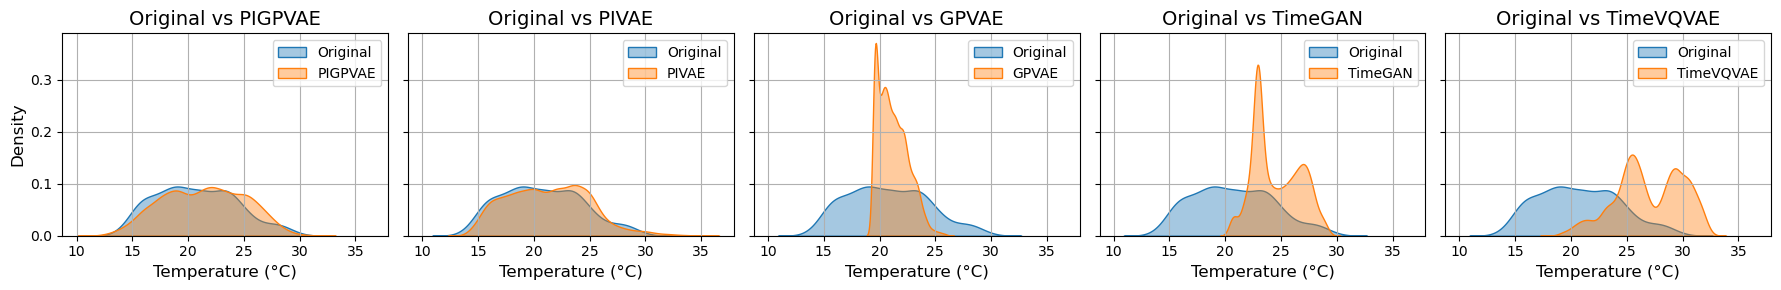

In [28]:
# Update datasets to include TimeVQVAE
datasets = [
    ("PIGPVAE", Gd_PIGPVAE),
    ("PIVAE", Gd_PIVAE),
    ("GPVAE", Gd_GPVAE),
    ("TimeGAN", Gd_timeGAN),
    ("TimeVQVAE", Gd_TimeVQVAE)
]

# Flatten the datasets for density plotting
original_flattened = original_data.flatten().numpy()
flattened_data = {name: data.flatten().numpy() for name, data in datasets}

# Plot configurations
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 3), sharex=True, sharey=True)
axes = axes.flatten()

# Generate each comparison plot
for i, (name, data) in enumerate(flattened_data.items()):
    sns.kdeplot(original_flattened, label="Original", fill=True, alpha=0.4, ax=axes[i])
    sns.kdeplot(data, label=name, fill=True, alpha=0.4, ax=axes[i])
    axes[i].set_xlabel("Temperature (°C)", fontsize=12)
    if i == 0:
        axes[i].set_ylabel("Density", fontsize=12)
    axes[i].legend(fontsize=10)
    axes[i].grid(True)
    axes[i].set_title(f"Original vs {name}", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig("figs/heating_densities.pdf", format="pdf", bbox_inches="tight")
plt.show()


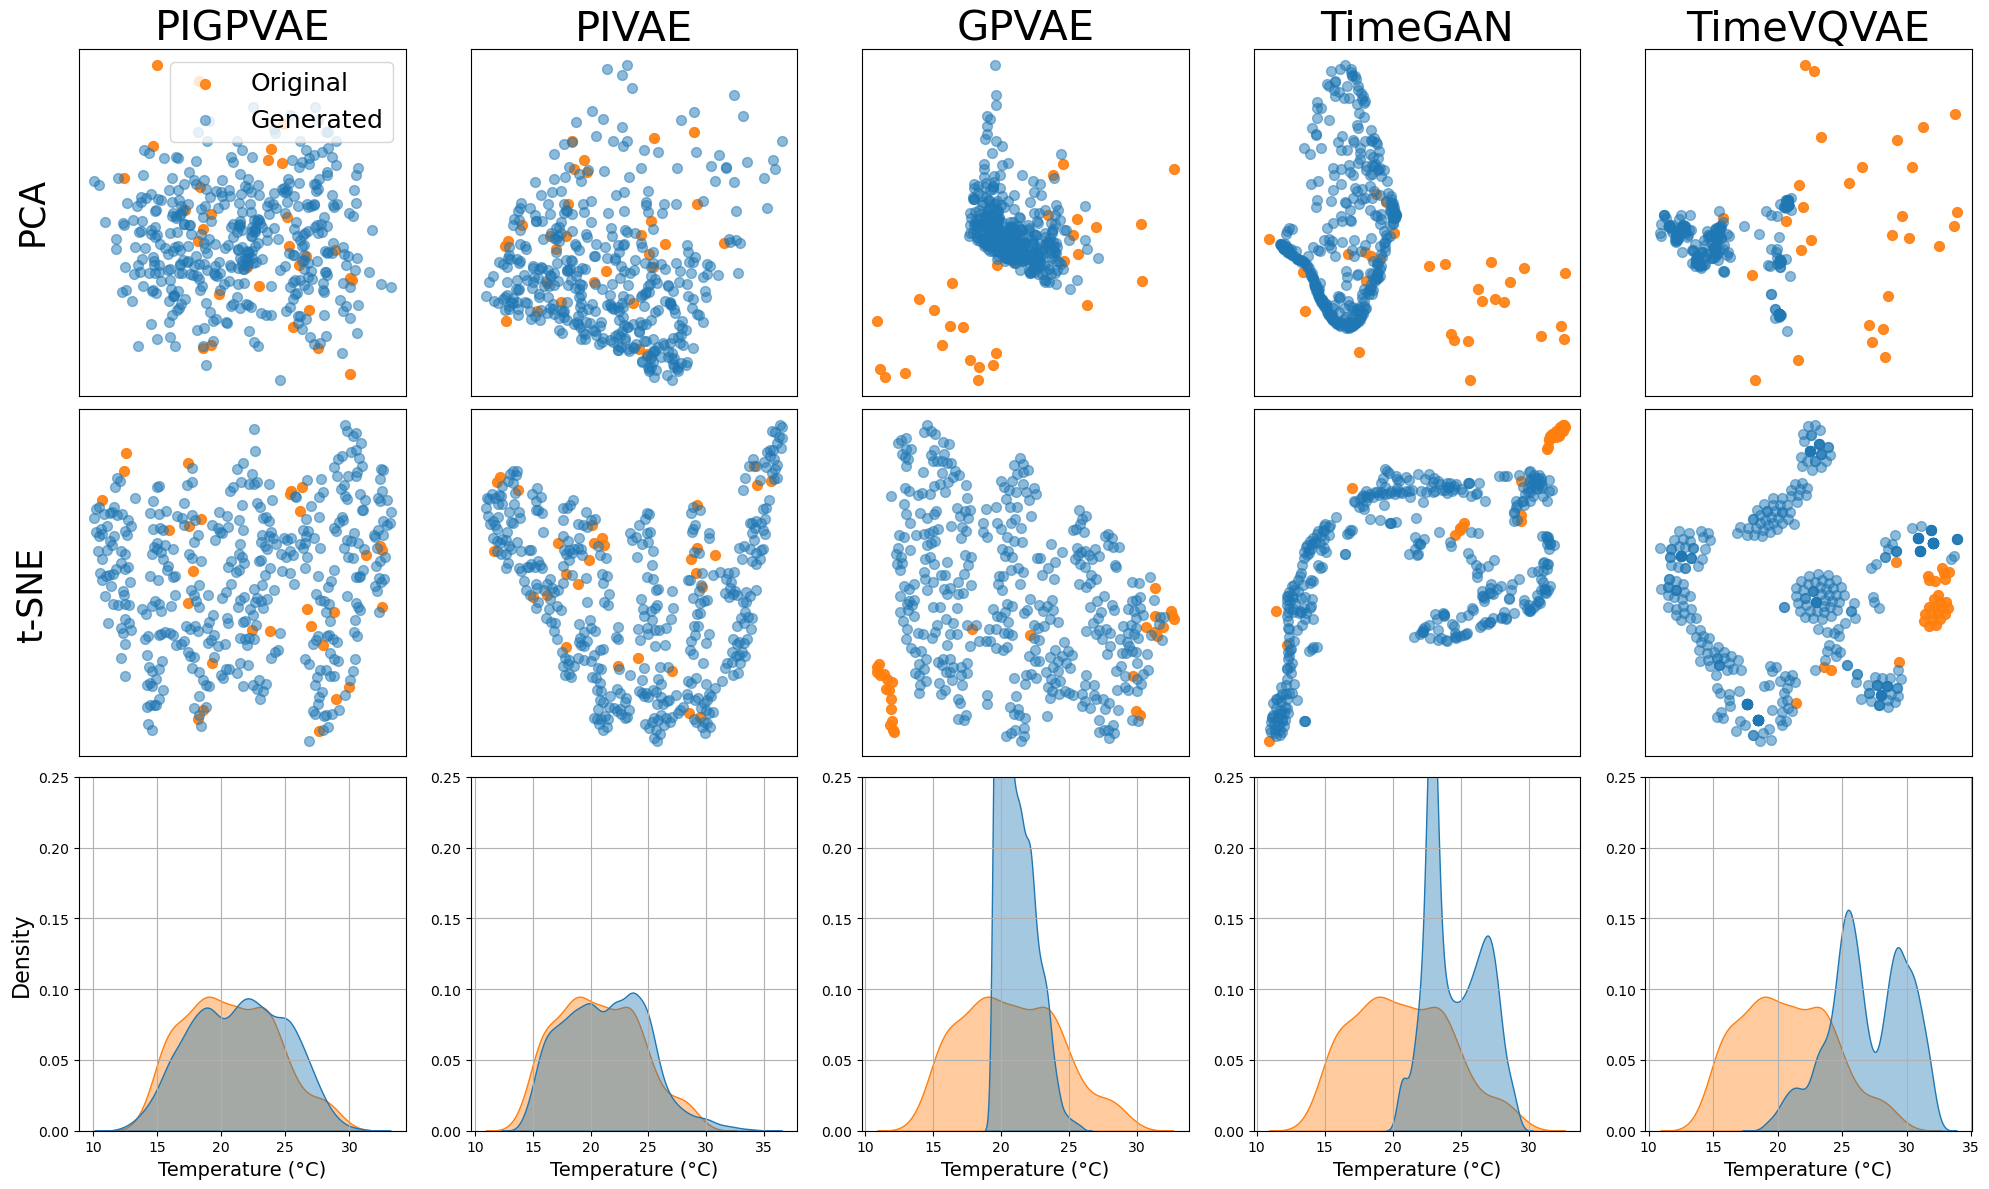

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming filtered_datasets, original_data, datasets, and flattened_data are defined

# Combined plot configuration
fig = plt.figure(figsize=(20, 12))

# Font sizes
title_fontsize = 30
label_fontsize = 25

# Set up subplots for PCA and t-SNE
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1])  # First row is taller for PCA/t-SNE
axes_pca_tsne = gs[0].subgridspec(2, len(filtered_datasets))  # PCA and t-SNE subplots

# Flatten the original data for PCA and t-SNE
original_flattened = [ts.numpy().flatten() if isinstance(ts, torch.Tensor) else ts.flatten() for ts in original_data]
original_flattened = np.vstack(original_flattened)  # Convert to 2D array

# Loop for PCA and t-SNE plots
for row, method in enumerate(["PCA", "t-SNE"]):
    for col, (name, data) in enumerate(filtered_datasets):
        ax = fig.add_subplot(axes_pca_tsne[row, col])
        
        # Flatten the generated data
        generated_flattened = [ts.numpy().flatten() if isinstance(ts, torch.Tensor) else ts.flatten() for ts in data]
        generated_flattened = np.vstack(generated_flattened)  # Convert to 2D array

        # Combine original and generated data
        combined_data = np.vstack([original_flattened, generated_flattened])
        labels = np.array(["Original"] * len(original_flattened) + ["Generated"] * len(generated_flattened))

        # Perform PCA or t-SNE
        if method == "PCA":
            pca = PCA(n_components=2)
            result = pca.fit_transform(combined_data)
        else:  # t-SNE
            tsne = TSNE(n_components=2, perplexity=30, random_state=42)
            result = tsne.fit_transform(combined_data)

        # Create scatter plot
        for label in ["Original", "Generated"]:
            subset = result[labels == label]
            if label == "Original":
                ax.scatter(subset[:, 0], subset[:, 1], label="Original", color="#ff7f0e", alpha=0.9, s=50)  # Orange for Original
            else:
                ax.scatter(subset[:, 0], subset[:, 1], label="Generated", color="#1f77b4", alpha=0.5, s=50)  # Blue for Generated

        # Set plot titles
        if row == 0:
            ax.set_title(name, fontsize=title_fontsize)
        
        # Remove x-axis and y-axis ticks and numbers
        ax.set_xticks([])
        ax.set_yticks([])

        # Add legend to the first column of the first row
        if col == 0 and row == 0:
            ax.legend(fontsize=18, loc="upper right")

# Add row labels for PCA and t-SNE
fig.text(0.01, 0.82, "PCA", fontsize=label_fontsize, rotation=90, va='center')
fig.text(0.01, 0.5, "t-SNE", fontsize=label_fontsize, rotation=90, va='center')

# Set up subplots for density plots in the second row
density_grid = gs[1].subgridspec(1, len(datasets))  # Define density subplots grid

# Flatten the datasets for density plotting
original_flattened = original_data.flatten().numpy()
flattened_data = {name: data.flatten().numpy() for name, data in datasets}

# Loop for density plots
for i, (name, data) in enumerate(flattened_data.items()):
    ax = fig.add_subplot(density_grid[0, i])  # Create a subplot in the grid
    # Swap colors: blue for Original, orange for Generated
    sns.kdeplot(original_flattened, label="Original", fill=True, alpha=0.4, ax=ax, color="#ff7f0e")  
    sns.kdeplot(data, label=name, fill=True, alpha=0.4, ax=ax, color="#1f77b4")  
    ax.set_xlabel("Temperature (°C)", fontsize=14)
    if i == 0:
        ax.set_ylabel("Density", fontsize=16)
    else:
        ax.set_ylabel(None)
    ax.grid(True)
    ax.set_ylim(0, 0.25)


# Adjust layout
plt.tight_layout()
plt.savefig("figs/PCA_tSNE_density_heating_limited.pdf", format="pdf", bbox_inches="tight")
plt.show()
